25
Model Accuracy: 0.8240
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5860
           1       0.67      0.39      0.49      1640

    accuracy                           0.82      7500
   macro avg       0.76      0.67      0.69      7500
weighted avg       0.81      0.82      0.81      7500


Final Training Log Loss: 0.3043
Final Test Log Loss: 0.4250


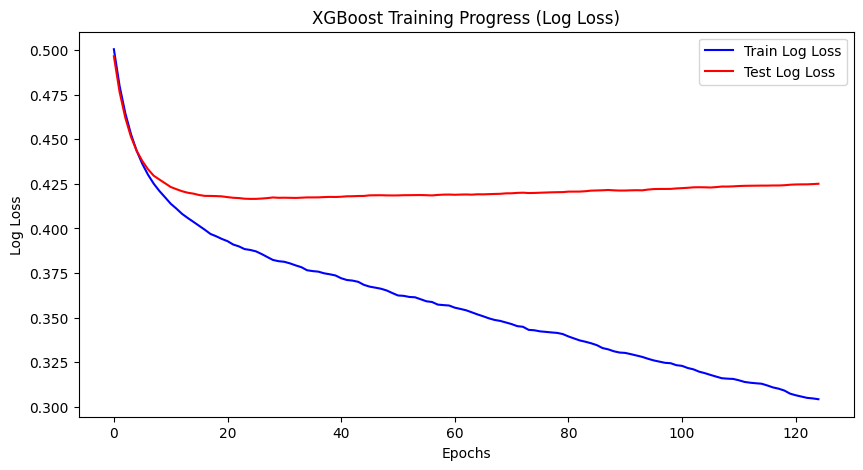

In [10]:
%run /home/jui/thesis-code/Thesis-code/rai-img-merged/Baseline-model.ipynb

In [11]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier

import warnings
warnings.filterwarnings('ignore')

# Select random 7500 samples using positional indexing
subset_indices = np.random.choice(len(y_train_og), 7500, replace=False)
X_train_subset = X_train_og.iloc[subset_indices]  # Use .iloc for positional indexing
y_train_subset = y_train_og[subset_indices]  # Direct positional indexing for NumPy array


def get_adversarial_examples(X_train_subset, pipeline, model):
    """
    Generate adversarial examples using the ZooAttack method.

    Args:
        X_train_subset (np.ndarray): Subset of training data (raw features).
        y_train_subset (np.ndarray): Corresponding labels for the subset.
        pipeline (Pipeline): The original pipeline containing preprocessing and model.

    Returns:
        np.ndarray: Adversarial examples.
    """
    # Extract the preprocessor and model from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']

    # Preprocess the subset of training data using the pipeline's preprocessor
    X_train_subset_preprocessed = preprocessor.transform(X_train_subset)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(
        model=model,
        nb_features=X_train_subset_preprocessed.shape[1],
        nb_classes=2)

    # Create the ZooAttack instance
    zoo = ZooAttack(
        classifier=art_classifier,
        confidence=0.0,
        targeted=False,
        learning_rate=1e-1,
        max_iter=50,
        binary_search_steps=10,
        initial_const=1e-3,
        abort_early=True,
        use_resize=False,
        use_importance=False,
        nb_parallel=5,
        batch_size=1,
        variable_h=0.01
    )

    # Generate adversarial examples
    x_train_adv = zoo.generate(X_train_subset_preprocessed)

    return x_train_adv

In [12]:
x_train_adv = get_adversarial_examples(X_train_subset, pipeline, model_baseline)
print(x_train_adv.shape)

ZOO:   0%|          | 0/7500 [00:00<?, ?it/s]

ZOO: 100%|██████████| 7500/7500 [12:22<00:00, 10.11it/s]

(7500, 24)


Accuracy on Test Set: 80.72%


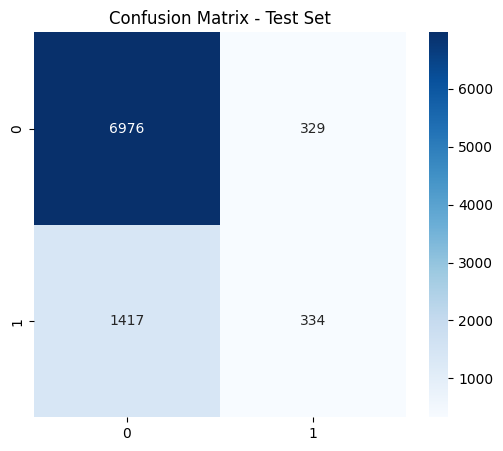

In [6]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Convert all datasets to NumPy arrays before training
xgb_model.fit(x_train_adv, y_train_subset,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [10]:
def label_flip_attack(y_train: np.ndarray, flip_percent: float) -> np.ndarray:
    """
    Flip labels in y_train by a specified percentage.
    
    Args:
        y_train (np.ndarray): Original training labels.
        flip_percent (float): Percentage of labels to flip (0-100).

    Returns:
        np.ndarray: Poisoned labels with flipped values.
    """
    y_poisoned = y_train.copy()
    n_samples = len(y_train)
    n_flip = int((flip_percent / 100) * n_samples)  # Number of labels to flip
    
    flip_indices = np.random.choice(np.arange(n_samples), size=n_flip, replace=False)

    # Flip binary labels (assuming labels are 0 and 1)
    y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]  # Flip 0->1 and 1->0
    
    return y_poisoned



Accuracy on Test Set: 75.81%


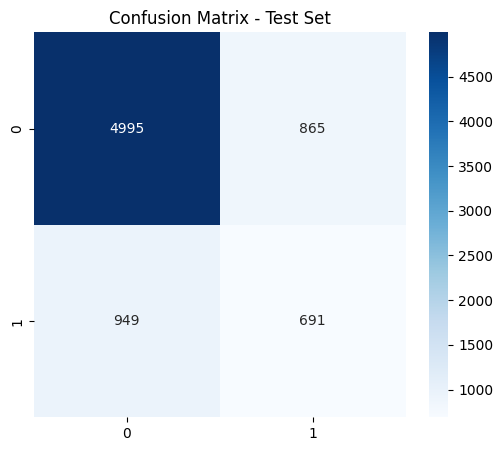

In [12]:
# Define the percentage of labels to flip
flip_percent = 35  # Flip 35% of labels

# Apply label flipping attack
y_train_poisoned = label_flip_attack(y_train_og, flip_percent)

# Step 2: Train model on poisoned labels
xgb_model.fit(X_train_og, y_train_poisoned, verbose=False)

# Step 3: Evaluate model on test set
y_pred_test = xgb_model.predict(X_test_og)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Step 4: Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [12]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights
from responsibleai.feature_metadata import FeatureMetadata
import seaborn as sns
import matplotlib.pyplot as plt

# Set up feature metadata for RAIInsights
feature_metadata = FeatureMetadata(categorical_features=categorical_features, dropped_features=[])

# Add the target feature back to the datasets
X_train_og_with_target = pd.DataFrame(x_train_adv, columns=feature_names)
X_train_og_with_target[target_feature] = y_train_subset.ravel()

X_test_og_with_target = X_test_og.copy()
X_test_og_with_target[target_feature] = y_test

sample_df = X_test_og_with_target.sample(n=5000, random_state=10)

# Remove the 'num_pipe__' prefix from train columns
X_train_og_with_target.columns = X_train_og_with_target.columns.str.replace('num_pipe__', '')

# Verify after renaming
print(X_train_og_with_target.columns)

'''
# Specify the stratification variable
stratify_by = 'AGE'

# Split the data into training and testing sets, with stratification
train, test = train_test_split(X_train_og_with_target, test_size=0.3, stratify=X_train_og_with_target[stratify_by])
sample_df, _ = train_test_split(
    train, 
    train_size=5000/len(train),  # Ensure we get exactly 5000 samples
    stratify=train[stratify_by],  # Maintain distribution
    random_state=42
)

# Check the distribution of the stratification variable in the training and testing sets
print("Train dataset:\n", sample_df[stratify_by].value_counts())'''

# Now, pass these modified DataFrames to RAIInsights
rai_insights = RAIInsights(model, X_train_og_with_target, sample_df, target_feature, 'classification', feature_metadata=feature_metadata)
from raiwidgets import ErrorAnalysisDashboard
y_test = y_test.flatten()
# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the label that they should have, and a list of 
                # strings of categorical feature names
#rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')
# Compute: Perform all tasks (this remains CPU-bound)
rai_insights.compute()
ResponsibleAIDashboard(rai_insights)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
Causal Effects
Current Status: Generating Causal Effects.
Current Status: Finished generating causal effects.
Time taken: 0.0 min 1.760898157954216e-05 sec
Counterfactual
Time taken: 0.0 min 6.1140162870287895e-06 sec
Error Analysis
Current Status: Generating error analysis reports.
Current Status: Finished generating error analysis reports.
Time taken: 0.0 min 0.37754297198262066 sec
Explanations
Current Status: Explaining 24 features
Current Status: Explained 24 features.
Time taken: 0.0 min 0.886572218965739 sec
ResponsibleAI started at http://localhost:8704
